

# Goal: predict which previously purchased products will be in a user’s next order

In [1]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import glob
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
zf = ZipFile('/Users/minga/DataSci/instacart-market-basket-analysis/aisles.csv.zip')
aisles = pd.read_csv(zf.open('aisles.csv'))

In [3]:
aisles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   aisle_id  134 non-null    int64 
 1   aisle     134 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.2+ KB


In [4]:
zf = ZipFile('/Users/minga/DataSci/instacart-market-basket-analysis/departments.csv.zip')
departments = pd.read_csv(zf.open('departments.csv'))

In [5]:
departments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   department_id  21 non-null     int64 
 1   department     21 non-null     object
dtypes: int64(1), object(1)
memory usage: 464.0+ bytes


In [6]:
zf = ZipFile('/Users/minga/DataSci/instacart-market-basket-analysis/products.csv.zip')
products = pd.read_csv(zf.open('products.csv'))

In [7]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     49688 non-null  int64 
 1   product_name   49688 non-null  object
 2   aisle_id       49688 non-null  int64 
 3   department_id  49688 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


In [8]:
zf = ZipFile('/Users/minga/DataSci/instacart-market-basket-analysis/order_products__prior.csv.zip')
order_products_prior = pd.read_csv(zf.open('order_products__prior.csv'))

In [9]:
order_products_prior.info(null_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 4 columns):
 #   Column             Non-Null Count     Dtype
---  ------             --------------     -----
 0   order_id           32434489 non-null  int64
 1   product_id         32434489 non-null  int64
 2   add_to_cart_order  32434489 non-null  int64
 3   reordered          32434489 non-null  int64
dtypes: int64(4)
memory usage: 989.8 MB


In [10]:
zf = ZipFile('/Users/minga/DataSci/instacart-market-basket-analysis/orders.csv.zip')
orders = pd.read_csv(zf.open('orders.csv'))

# Selected only 20% of orders

In [11]:
orders = orders.sample(frac=0.20)

In [12]:
orders.shape

(684217, 7)

In [13]:
orders.order_id.nunique()

684217

In [14]:
orders.info(verbose = True, null_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 684217 entries, 2382392 to 2166322
Data columns (total 7 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   order_id                684217 non-null  int64  
 1   user_id                 684217 non-null  int64  
 2   eval_set                684217 non-null  object 
 3   order_number            684217 non-null  int64  
 4   order_dow               684217 non-null  int64  
 5   order_hour_of_day       684217 non-null  int64  
 6   days_since_prior_order  642799 non-null  float64
dtypes: float64(1), int64(5), object(1)
memory usage: 41.8+ MB


In [15]:
zf = ZipFile('/Users/minga/DataSci/instacart-market-basket-analysis/order_products__train.csv.zip')
order_products_train = pd.read_csv(zf.open('order_products__train.csv'))

In [16]:
order_products_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1384617 entries, 0 to 1384616
Data columns (total 4 columns):
 #   Column             Non-Null Count    Dtype
---  ------             --------------    -----
 0   order_id           1384617 non-null  int64
 1   product_id         1384617 non-null  int64
 2   add_to_cart_order  1384617 non-null  int64
 3   reordered          1384617 non-null  int64
dtypes: int64(4)
memory usage: 42.3 MB


### Feature engineering on products

In [17]:
priors_orders_detail = orders.merge(right=order_products_prior, how='inner', on='order_id')

In [18]:
# check previously how many times the user has purchased the same item on this order using cumcount() 
priors_orders_detail['_user_buy_product_times'] = priors_orders_detail.groupby(['user_id', 'product_id']).cumcount() + 1
priors_orders_detail.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,_user_buy_product_times
0,821738,143367,prior,13,6,9,5.0,19836,1,0,1
1,821738,143367,prior,13,6,9,5.0,33351,2,0,1
2,821738,143367,prior,13,6,9,5.0,40332,3,0,1
3,2737161,196130,prior,59,2,12,2.0,39475,1,1,1
4,2737161,196130,prior,59,2,12,2.0,17872,2,1,1


In [19]:
# _prod_tot_cnts: how many times the product were purchased 
# _prod_reorder_tot_cnts: how many times the product were re-purchased
# _prod_order_once: the product was purchased only once
#_prod_buy_second_time_total_cnt: the product was purchased more than one time
# _prod_reorder_ratio: the ratio of product being reordered

prd = pd.concat([priors_orders_detail.groupby('product_id')['user_id'].count().rename('_prod_tot_cnts'),
                priors_orders_detail.groupby('product_id')['reordered'].sum().rename('_prod_reorder_tot_cnts'),
                priors_orders_detail.groupby('product_id')['_user_buy_product_times'].apply(
                    lambda x: sum(x==1)).rename('_prod_buy_first_time_total_cnt'),
                priors_orders_detail.groupby('product_id')['_user_buy_product_times'].apply(
                    lambda x: sum(x>1)).rename('_prod_buy_multi_time_total_cnt')], axis = 1).reset_index()

In [20]:
prd['_prod_reorder_ratio'] = prd._prod_reorder_tot_cnts/prd._prod_tot_cnts

### Continuous feature engineering on user

In [21]:
# _user_total_orders: total number of orders for each user
# _user_mean_days_since_prior_order: the average days between orders
#_user_max_days_since_prior_order: the max days between orders
users = pd.concat([orders[orders.eval_set == 'prior'].groupby('user_id')['order_number'].max().rename('_user_total_orders'),
                   orders[orders.eval_set == 'prior'].groupby('user_id')['days_since_prior_order'].mean().rename(
                       '_user_mean_days_since_prior_order'),
                   orders[orders.eval_set == 'prior'].groupby('user_id')['days_since_prior_order'].max().rename(
                       '_user_max_days_since_prior_order'), ], axis =1).reset_index()

In [22]:
# _user_total_products: how many products the user purchased
# _user_distinct_products: number of unique products the user purchased
users_2 = pd.concat([priors_orders_detail.groupby('user_id')['product_id'].count().rename('_user_total_products'),
                priors_orders_detail.groupby('user_id')['product_id'].nunique().rename('_user_distinct_products'),
                priors_orders_detail['user_id']], axis = 1)

In [23]:
users = users.merge(users_2,how = 'inner')

In [24]:
# _user_average_basket: average number of products for each order
users['_user_average_basket'] = users._user_total_products/users._user_total_orders

In [25]:
users_3 = orders[orders.eval_set != "prior"][['user_id', 'order_id', 'eval_set', 'days_since_prior_order']]
users_3.rename(index=str, columns={'days_since_prior_order': 'time_since_last_order'}, inplace=True)

In [26]:
users = users.merge(users_3, how='inner')

### Continuous feature engineering on database

In [27]:
# _up_order_count: how many times the user has purchased the product
# _up_average_cart_position: the avearge position the item was placed into the shopping cart

data = pd.concat([priors_orders_detail.groupby(['user_id', 'product_id'])['order_number'].count().rename('_up_order_count'),
                priors_orders_detail.groupby(['user_id', 'product_id'])['add_to_cart_order'].mean().rename(
                    '_up_average_cart_position')], axis = 1).reset_index()

In [28]:
data = data.merge(prd, how='inner', on='product_id')
data.head()

,user_id,product_id,_up_order_count,_up_average_cart_position,_prod_tot_cnts,_prod_reorder_tot_cnts,_prod_buy_first_time_total_cnt,_prod_buy_multi_time_total_cnt,_prod_reorder_ratio
0,1,196,2,3.0,7028,5432,3571,3457,0.772908
1,31,196,1,14.0,7028,5432,3571,3457,0.772908
2,52,196,2,5.5,7028,5432,3571,3457,0.772908
3,67,196,2,1.5,7028,5432,3571,3457,0.772908
4,81,196,1,2.0,7028,5432,3571,3457,0.772908


In [29]:
"""
# release Memory
del priors_orders_detail, orders, prd, users_2, users_3

# Importing gc module
import gc
 
# Returns the number of
# objects it has collected
# and deallocated
collected = gc.collect()
 
# Prints Garbage collector
# as 0 object
print("Garbage collector: collected",
          "%d objects." % collected)
"""

'\n# release Memory\ndel priors_orders_detail, orders, prd, users_2, users_3\n\n# Importing gc module\nimport gc\n \n# Returns the number of\n# objects it has collected\n# and deallocated\ncollected = gc.collect()\n \n# Prints Garbage collector\n# as 0 object\nprint("Garbage collector: collected",\n          "%d objects." % collected)\n'

In [30]:
users = users[users.eval_set == 'train']

In [31]:
data = data.merge(users, how='inner', on='user_id')
data.head()

,user_id,product_id,_up_order_count,_up_average_cart_position,_prod_tot_cnts,_prod_reorder_tot_cnts,_prod_buy_first_time_total_cnt,_prod_buy_multi_time_total_cnt,_prod_reorder_ratio,_user_total_orders,_user_mean_days_since_prior_order,_user_max_days_since_prior_order,_user_total_products,_user_distinct_products,_user_average_basket,order_id,eval_set,time_since_last_order
0,120,196,1,2.0,7028,5432,3571,3457,0.772908,1,NaN,NaN,NaN,NaN,NaN,961032,train,30.0
1,120,196,1,2.0,7028,5432,3571,3457,0.772908,1,NaN,NaN,NaN,NaN,NaN,961032,train,30.0
2,120,196,1,2.0,7028,5432,3571,3457,0.772908,1,NaN,NaN,NaN,NaN,NaN,961032,train,30.0
3,120,46149,1,1.0,1689,1369,810,879,0.810539,1,NaN,NaN,NaN,NaN,NaN,961032,train,30.0
4,120,46149,1,1.0,1689,1369,810,879,0.810539,1,NaN,NaN,NaN,NaN,NaN,961032,train,30.0


In [32]:
# add user_id to train set
order_products_train = order_products_train.merge(right=orders[['order_id', 'user_id']], how='left', on='order_id')
data = data.merge(order_products_train[['user_id', 'product_id', 'reordered']], on=['user_id', 'product_id'], how='left')

In [33]:
train = data.loc[data.eval_set == "train",:]
train.drop(['eval_set', 'user_id', 'product_id', 'order_id'], axis=1, inplace=True)
train.loc[:, 'reordered'] = train.reordered.fillna(0)

In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split (
    train.drop('reordered', axis = 1), train.reordered, test_size = 0.2, random_state = 42)


In [35]:
X_train.shape

(36863590, 14)

### Lightgbm

In [36]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
lgbm_model = LGBMClassifier()
lgbm_model.fit(X_train, y_train)
y_pred = lgbm_model.predict(X_test)

In [37]:
y_pred[:5]

array([0., 0., 0., 0., 0.])

In [38]:
#converting probabilities into 0 or 1
for i in range(0,len(y_pred)):
    if y_pred[i]>=.5:       # setting threshold to .5
       y_pred[i]=1
    else:  
       y_pred[i]=0

In [39]:
#calculating accuracy
from sklearn.metrics import accuracy_score
accuracy_lgbm = accuracy_score(y_pred,y_test)
accuracy_lgbm

0.878295202485965

In [40]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

         0.0       0.88      0.99      0.93   8034461
         1.0       0.66      0.11      0.18   1181437

    accuracy                           0.88   9215898
   macro avg       0.77      0.55      0.56   9215898
weighted avg       0.85      0.88      0.84   9215898



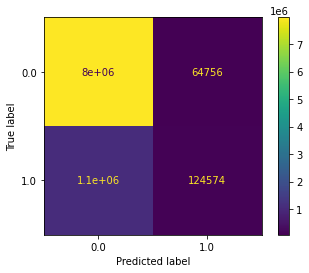

In [41]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = lgbm_model.classes_)
disp.plot(cmap = 'viridis');

In [42]:
feature_importances = lgbm_model.feature_importances_
feature_importances = pd.DataFrame(zip(feature_importances, X_train.columns), 
                                  columns = ['feature_importance', 'attribute']).sort_values('feature_importance', 
                                                                                             ascending = False)
feature_importances

,feature_importance,attribute
7,495,_user_total_orders
6,418,_prod_reorder_ratio
8,402,_user_mean_days_since_prior_order
1,349,_up_average_cart_position
13,295,time_since_last_order
0,258,_up_order_count
9,234,_user_max_days_since_prior_order
2,203,_prod_tot_cnts
5,123,_prod_buy_multi_time_total_cnt
4,113,_prod_buy_first_time_total_cnt


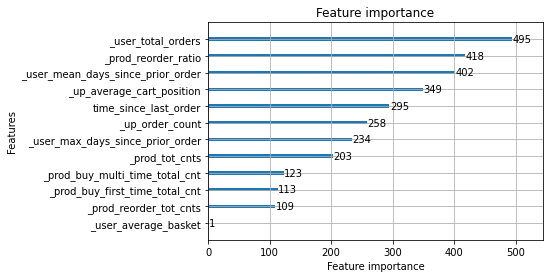

In [43]:
from lightgbm import plot_importance

lgb.plot_importance(lgbm_model);

### XGBoost

In [44]:
from xgboost import XGBClassifier
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

[22:07:12] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [45]:
#converting probabilities into 0 or 1
for i in range(0,len(y_pred)):
    if y_pred[i]>=.5:       # setting threshold to .5
       y_pred[i]=1
    else:  
       y_pred[i]=0

In [46]:
#calculating accuracy
from sklearn.metrics import accuracy_score
accuracy_xgbm = accuracy_score(y_pred,y_test)
accuracy_xgbm

0.883889122904789

In [47]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

         0.0       0.89      0.99      0.94   8034461
         1.0       0.73      0.15      0.25   1181437

    accuracy                           0.88   9215898
   macro avg       0.81      0.57      0.59   9215898
weighted avg       0.87      0.88      0.85   9215898



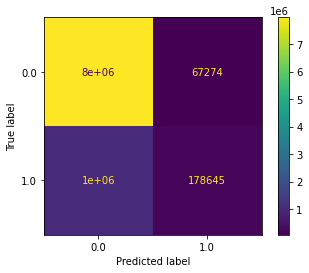

In [48]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = xgb_model.classes_)
disp.plot();

In [49]:
feature_importances = xgb_model.feature_importances_
feature_importances = pd.DataFrame(zip(feature_importances, X_train.columns), 
                                  columns = ['feature_importance', 'attribute']).sort_values('feature_importance', 
                                                                                             ascending = False)
feature_importances

,feature_importance,attribute
0,0.384904,_up_order_count
6,0.119769,_prod_reorder_ratio
7,0.106106,_user_total_orders
13,0.065768,time_since_last_order
5,0.064471,_prod_buy_multi_time_total_cnt
9,0.044660,_user_max_days_since_prior_order
8,0.043649,_user_mean_days_since_prior_order
1,0.043427,_up_average_cart_position
3,0.042757,_prod_reorder_tot_cnts
2,0.037197,_prod_tot_cnts


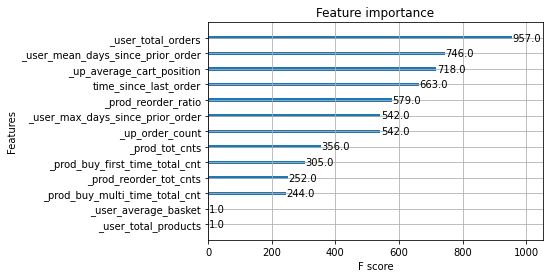

In [50]:
from xgboost import plot_importance
plot_importance(xgb_model);